# **Sberbank LightAutoML (LAMA)**

*Код данного ноутбука позаимствован из официального репозитория библиотеки https://github.com/sberbank-ai-lab/LightAutoML*

### Install LightAutoML

In [1]:
#! pip install -U lightautoml

### Import necessary libraries

In [2]:
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

[2021-07-20 15:13:32,248] (WARNING): /usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)



### Parameters

In [3]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 60 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name

### Fix torch number of threads and numpy seed

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### Example data load

In [5]:
DATASET_DIR = './example_data/test_data_files'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/example_data/test_data_files/sampled_app_train.csv'

In [6]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

CPU times: user 34 µs, sys: 0 ns, total: 34 µs
Wall time: 38.6 µs


In [7]:
%%time

data = pd.read_csv(DATASET_FULLNAME)

CPU times: user 381 ms, sys: 80.5 ms, total: 462 ms
Wall time: 328 ms


In [8]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,270000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.072508,-18590,-226,-2432.0,-2137,NaN,1,1,0,1,0,0,High skill tech staff,2.0,1,1,FRIDAY,14,0,1,1,0,0,0,...,0.0701,0.0684,0.0078,0.0738,reg oper account,block of flats,0.0686,Panel,No,0.0,0.0,0.0,0.0,-1275.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,675000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-20316,-3822,-13156.0,-3758,NaN,1,1,1,1,0,0,Security staff,2.0,2,2,WEDNESDAY,15,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,-1732.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,270000.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.031329,-9545,-1076,-4077.0,-1058,18.0,1,1,0,1,0,0,Laborers,4.0,2,2,THURSDAY,12,0,0,0,0,0,0,...,NaN,0.0023,NaN,0.0000,NaN,block of flats,0.0018,Wooden,No,4.0,1.0,4.0,1.0,-1597.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,112500.0,Unaccompanied,Working,Higher education,Married,With parents,0.008474,-11421,-2272,-5106.0,-1556,NaN,1,1,0,1,0,0,NaN,3.0,2,2,FRIDAY,15,0,0,0,0,0,0,...,NaN,0.0343,NaN,0.0133,NaN,block of flats,0.0214,"Stone, brick",No,0.0,0.0,0.0,0.0,-1069.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,1354500.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.008474,-13203,-1775,-5743.0,-4256,9.0,1,1,1,1,1,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,...,0.0761,0.0878,0.0039,0.0043,NaN,block of flats,0.0753,Panel,No,0.0,0.0,0.0,0.0,-1104.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


### Some user feature preparation

In [9]:
%%time

data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

data['constant'] = 1
data['allnan'] = np.nan

data['report_dt'] = np.datetime64('2018-01-01')

data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

[2021-07-20 15:13:34,761] (INFO): NumExpr defaulting to 2 threads.


CPU times: user 146 ms, sys: 14.3 ms, total: 160 ms
Wall time: 165 ms


### Data splitting for train-test

In [10]:
%%time

train_data, test_data = train_test_split(data, 
                                         test_size=TEST_SIZE, 
                                         stratify=data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)
logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

[2021-07-20 15:13:34,882] (INFO): Data splitted. Parts sizes: train_data = (8000, 125), test_data = (2000, 125)


CPU times: user 19.1 ms, sys: 1.72 ms, total: 20.8 ms
Wall time: 20.6 ms


In [11]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,...,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.019101,-2282.0,-3618,NaN,1,1,0,1,0,0,Sales staff,3.0,2,2,TUESDAY,12,0,0,0,0,0,0,Self-employed,NaN,...,block of flats,0.0726,"Stone, brick",No,2.0,0.0,2.0,0.0,-327.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1985-06-28,2012-06-21,1,NaN,2018-01-01
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,225000.0,Family,Pensioner,Higher education,Married,House / apartment,0.008575,-6264.0,-4008,NaN,1,0,0,1,0,0,NaN,2.0,2,2,SUNDAY,12,0,0,0,0,0,0,XNA,NaN,...,block of flats,0.2889,"Stone, brick",No,2.0,0.0,2.0,0.0,-1002.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,1953-12-27,2018-01-01,1,NaN,2018-01-01
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,337500.0,Unaccompanied,Working,Incomplete higher,Married,House / apartment,0.026392,-8007.0,-4693,NaN,1,1,1,1,1,0,NaN,2.0,2,2,SUNDAY,14,0,0,0,0,0,0,Business Entity Type 3,0.803434,...,block of flats,0.0811,Panel,No,1.0,0.0,1.0,0.0,-1520.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,1975-06-21,2016-06-17,1,NaN,2018-01-01
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.025164,-1889.0,-3102,64.0,1,1,1,1,0,0,Core staff,3.0,2,2,THURSDAY,15,0,0,0,0,0,0,Self-employed,0.265465,...,block of flats,0.0572,Block,No,3.0,0.0,3.0,0.0,-1042.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1988-04-27,2009-06-05,1,NaN,2018-01-01
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,202500.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.031329,-7976.0,-4276,NaN,1,1,0,1,0,0,Core staff,2.0,2,2,MONDAY,11,0,0,0,0,0,0,School,0.807457,...,block of flats,0.0099,"Stone, brick",No,0.0,0.0,0.0,0.0,-1248.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,1975-06-13,1997-01-22,1,NaN,2018-01-01


### ========= AutoML preset usage =========

### Create Task

In [12]:
%%time

task = Task('binary', )

CPU times: user 3.96 ms, sys: 0 ns, total: 3.96 ms
Wall time: 4.08 ms


### Setup columns roles

In [13]:
%%time

roles = {'target': TARGET_NAME,
         DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt',
         }

CPU times: user 51 µs, sys: 11 µs, total: 62 µs
Wall time: 67.5 µs


### Create AutoML from preset

In [14]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 60 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (8000, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 49.76215720176697 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6864238711505257
Linear model: C = 5e-05 score = 0.7053952777287767
Linear model: C = 0.0001 score = 0.7230570211310143
Linear model: C = 0.0005 score = 0.7543766805116773
Linear model: C = 0.001 score = 0.7615504273778405
Linear model: C = 0.005 score = 0.7633144634924709
Linear model: C = 0.01 score = 0.7603049109696318
Linear model: C = 0.05 score = 0.7481223706507155

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.70977783203125
Linear model: C = 5e-05 score = 0.7208676545516305
Linear model: C = 0.0001 score = 0.7273055366847826
Lin

Time limit exceeded after calculating fold 1


Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 45.635210275650024
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.744696
[200]	valid's auc: 0.748887
[300]	valid's auc: 0.751939
[400]	valid's auc: 0.751656
[500]	valid's auc: 0.750923
Early stopping, best iteration is:
[324]	valid's auc: 0.753623
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.756729
[200]	valid's auc: 0.762032
[300]	valid's auc: 0.763785
[400]	valid's auc: 0.764175


Time limit exceeded after calculating fold 0


Early stopping, best iteration is:
[256]	valid's auc: 0.765319
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	test: 0.5524667	best: 0.5524667 (0)	total: 58.9ms	remaining: 4m 54s
100:	test: 0.7305462	best: 0.7305462 (100)	total: 763ms	remaining: 37s
200:	test: 0.7351113	best: 0.7359452 (195)	total: 1.45s	remaining: 34.6s
300:	test: 0.7144934	best: 0.7369662 (222)	total: 2.12s	remaining: 33.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7369661786
bestIteration = 222

Shrink model to first 223 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	test: 0.5724514	best: 0.5724514 (0)	total: 7.82ms	remaining: 39.1s
100:	test: 0.7228632	best: 0.7255700 (64)	total: 693ms	remaining: 33.6s
200:	test: 0.7243069	best: 0.7296408 (122)	total: 1.37s	remaining: 32.8s
Stopped by overfitting detector  (100 iterat

Time limit exceeded after calculating fold 2


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7004447605
bestIteration = 541

Shrink model to first 542 iterations.
Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
Optuna may run 1 secs


[2021-07-20 15:14:13,958] (INFO): A new study created in memory with name: no-name-b62078b5-f1e3-4b9d-b73f-40716709c958


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5191344	best: 0.5191344 (0)	total: 7.57ms	remaining: 37.8s
100:	test: 0.7411197	best: 0.7443912 (71)	total: 585ms	remaining: 28.4s
200:	test: 0.7488119	best: 0.7488654 (194)	total: 1.17s	remaining: 27.9s
300:	test: 0.7466844	best: 0.7520995 (224)	total: 1.73s	remaining: 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7520994703
bestIteration = 224

Shrink model to first 225 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-07-20 15:14:16,001] (INFO): Trial 0 finished with value: 0.7520994702546092 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7520994702546092.


Time left 19.128796577453613


Time limit exceeded in one of the tasks. AutoML will blend level 1 models.


Blending: Optimization starts with equal weights and score 0.7296819610441737
Blending, iter 0: score = 0.7306998654025421, weights = [0.34117138 0.5221249  0.13670374]
Blending, iter 1: score = 0.7307175989279493, weights = [0.37051138 0.49887282 0.13061585]
Blending, iter 2: score = 0.7307175989279493, weights = [0.37051138 0.49887282 0.13061585]
No score update. Terminated

Automl preset training completed in 41.12 seconds.


[2021-07-20 15:14:16,264] (INFO): oof_pred:
array([[0.02867683],
       [0.03838797],
       [0.04217594],
       ...,
       [       nan],
       [0.16470957],
       [       nan]], dtype=float32)
Shape = (8000, 1)


CPU times: user 54.6 s, sys: 1.38 s, total: 56 s
Wall time: 41.2 s


CPU times: user 204 ms, sys: 6.84 ms, total: 211 ms
Wall time: 216 ms


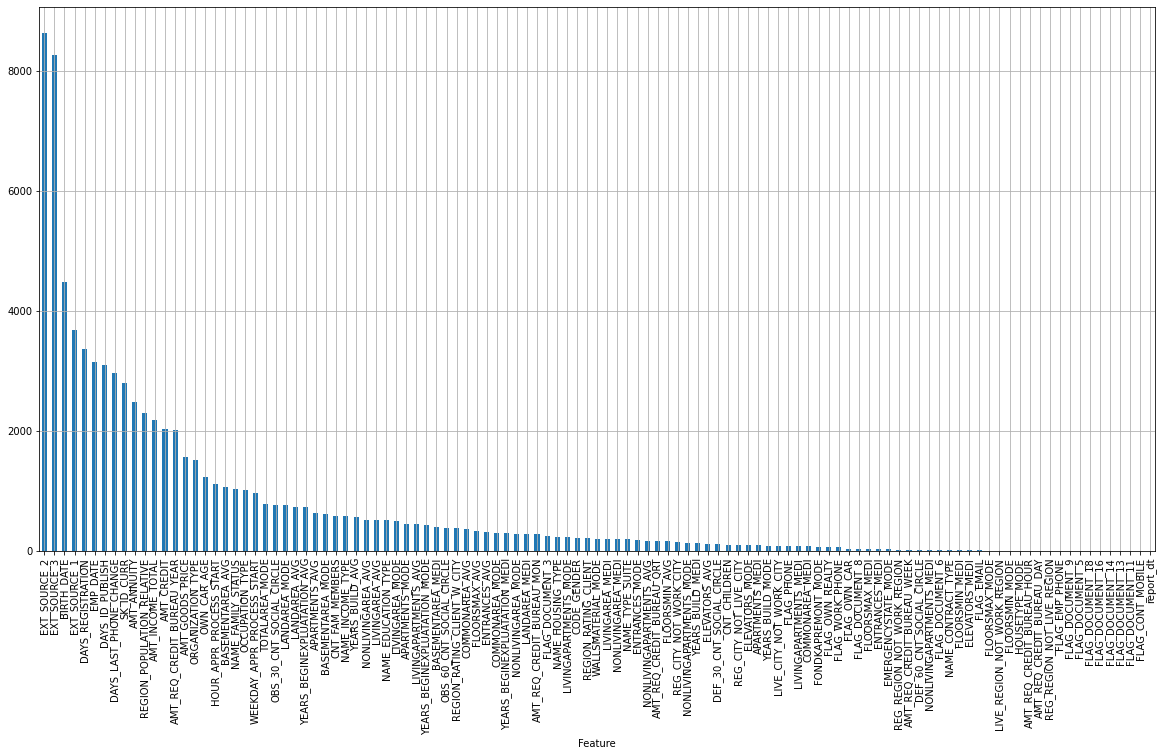

In [15]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

LightAutoML used 111 feats
1/111 Calculated score for FLOORSMIN_AVG: 0.0002140
2/111 Calculated score for LIVINGAPARTMENTS_MEDI: -0.0007269
3/111 Calculated score for FLAG_DOCUMENT_13: 0.0008186
4/111 Calculated score for BASEMENTAREA_AVG: 0.0001495
5/111 Calculated score for NAME_EDUCATION_TYPE: 0.0003465
6/111 Calculated score for FLAG_DOCUMENT_3: 0.0006182
7/111 Calculated score for NAME_INCOME_TYPE: 0.0006216
8/111 Calculated score for ENTRANCES_MEDI: 0.0004110
9/111 Calculated score for LANDAREA_AVG: 0.0000849
10/111 Calculated score for WEEKDAY_APPR_PROCESS_START: 0.0014130
11/111 Calculated score for REG_REGION_NOT_LIVE_REGION: -0.0000102
12/111 Calculated score for DAYS_ID_PUBLISH: 0.0006454
13/111 Calculated score for NAME_TYPE_SUITE: -0.0000951
14/111 Calculated score for FLAG_DOCUMENT_8: -0.0007235
15/111 Calculated score for ELEVATORS_MODE: 0.0005774
16/111 Calculated score for LIVINGAREA_MEDI: -0.0000917
17/111 Calculated score for YEARS_BUILD_MODE: 0.0002955
18/111 Calcul

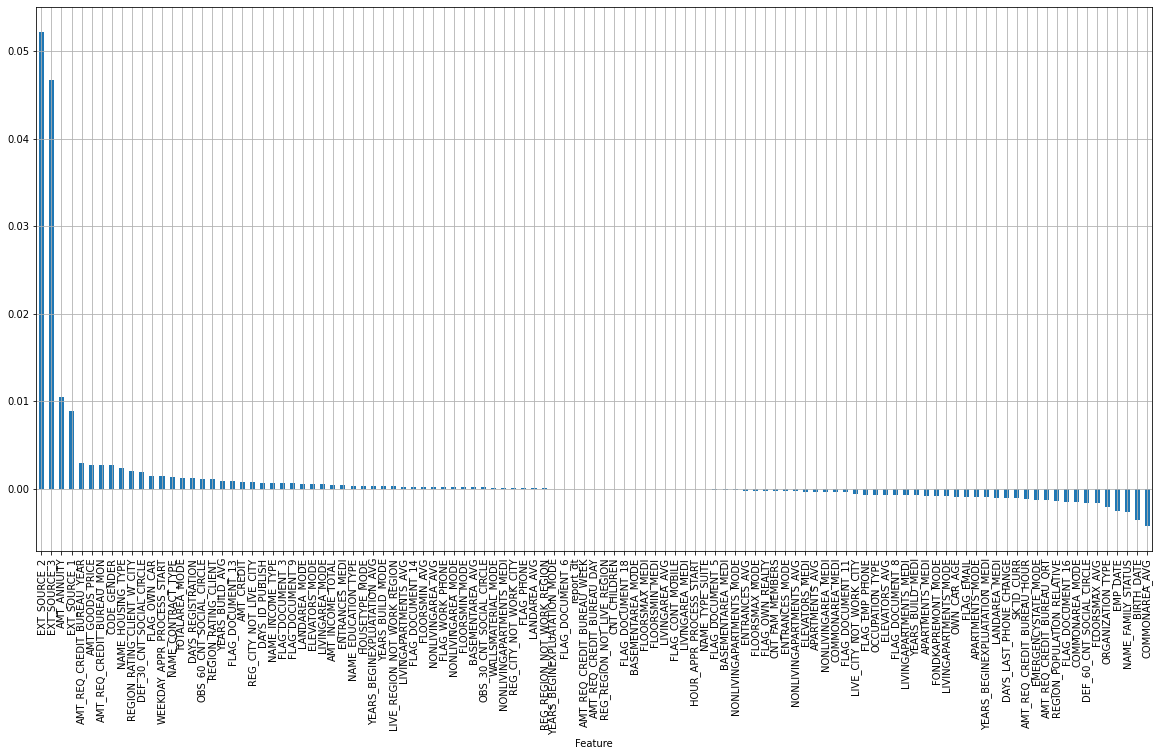

In [16]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl.get_feature_scores('accurate', test_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

### Predict to test data and check scores

In [25]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
# logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-07-20 15:20:07,127] (INFO): Prediction for test data:
array([[0.07828486],
       [0.08115251],
       [0.03277324],
       ...,
       [0.05830524],
       [0.04996853],
       [0.2248071 ]], dtype=float32)
Shape = (2000, 1)
[2021-07-20 15:20:07,129] (INFO): Check scores...
[2021-07-20 15:20:07,138] (INFO): TEST score: 0.728125


CPU times: user 554 ms, sys: 4.93 ms, total: 559 ms
Wall time: 496 ms


In [23]:
oof_pred.data[:,0]

array([0.02867683, 0.03838797, 0.04217594, ...,        nan, 0.16470957,
              nan], dtype=float32)